In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import cross_val_score
from sklearn import svm

import dionysus as d
import sklearn_tda as tda

from biomarker.data_collection import *

Cython not found--WassersteinDistance not available
Gudhi not found--GraphInducedComplex not available
data_collection


In [2]:
EXCLUDE_KEYS = [206, 205, 184, 183, 82, 81, 45]
TEST_KEYS = [217, 216]#, 215, 214, 213, 212, 211, 210, 209]
NUM_TEST = 10
SIGMA = 1

C = 1
EPSILON = 0.1
GAMMA = 0.1
LIM = 5
MUL = 10

In [3]:
def compute_diagram(points, k=3):
    r = np.max(pdist(points, 'euclidean'))
    f = d.fill_rips(points, k, r)
    m = d.homology_persistence(f)
    return d.init_diagrams(m, f)

def get_max_diag_dim(dgms, h=1):
    m = 0
    for d in dgms:
        n = len(d[h])
        if n > m:
            m = n
    return m

def kernelize_diagrams_rbf(dgms, h=1, sigma=SIGMA, default=10):
    D = np.zeros(shape=(len(dgms), len(dgms)))
    for i in range(len(dgms)):
        print('step: ', i)
        for j in range(len(dgms)):
            if i == j:
                D[i,j] = 0.0
            else:
                xi = np.zeros(((len(dgms[i][h]) if len(dgms[i][h]) > len(dgms[j][h]) else len(dgms[j][h])), 2))
                xj = np.zeros(xi.shape)
                if xj.shape[0] > 0:
                    for ip in range(len(dgms[i][h])):
                        xi[ip,0] = dgms[i][h][ip].birth
                        xi[ip,1] = dgms[i][h][ip].death
                    for jp in range(len(dgms[j][h])):
                        xj[jp,0] = dgms[j][h][ip].birth
                        xj[jp,1] = dgms[j][h][ip].death
                    xi[xi[:,1] >= 1E108] = 0
                    xj[xj[:,1] >= 1E108] = 0
                    D[i,j] = np.exp(np.power((np.linalg.norm(xi - xj, 2)), 2)/(2*sigma))
    #                 D[D >= 1E108] = 0
                else:
                    D[i,j] = 0
                D = np.nan_to_num(D)
    return D

def kernelize_diagrams(dgms, h=1, sigma=SIGMA):
    D = np.zeros(shape=(len(dgms), len(dgms)))
    for i in range(len(dgms)):
        print('step: ', i)
        for j in range(len(dgms)):
            if i == j:
                D[i,j] = 0.0
            else:
                D[i,j] = d.bottleneck_distance(dgms[i][h], dgms[j][h])
#                 D[i,j] = np.exp(d.wasserstein_distance(dgms[i][h], dgms[j][h], q=2)/2*sigma)
    D = np.nan_to_num(D)
    return D


def compute_sample_weights(y, lim=LIM, mul=MUL):
    ret = np.ones(y.shape[0])
    for i in range(y.shape[0]):
        v = y[i]
        if v < lim:
            ret[i] = (lim-v)*mul
    return ret

def create_train_test_matrices(train_keys, test_keys):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    test_idxs = list(excel[np.isin(excel['Key'], test_keys)].index)
    excel_test = excel.iloc[test_idxs]
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
    y_buck_test = excel_test['Output: logKbucket'].values
    
    excel_train = excel.drop(test_idxs, axis=0)
    L_train = get_filename_list(excel_train['Associated data'])
    y_train = excel_train['Output: logK'].values
    y_buck_train = excel_train['Output: logKbucket'].values
    
    x1_train, x1_dims = create_x1_matrix(L_train, return_dims=True)
    x4_train, x4_dims = create_x4_matrix(L_train, return_dims=True)
    x5_train, x5_dims = create_x5_matrix(L_train, return_dims=True)
    x6_train, x6_dims = create_x6_matrix(L_train, return_dims=True)
    x7_train, x7_dims = create_x7_matrix(L_train, return_dims=True)
    
    x1_test = create_x1_matrix(L_test, max_dims=x1_dims)
    x4_test = create_x4_matrix(L_test, max_dims=x4_dims)
    x5_test = create_x5_matrix(L_test, max_dims=x5_dims)
    x6_test = create_x6_matrix(L_test, max_dims=x6_dims)
    x7_test = create_x7_matrix(L_test, max_dims=x7_dims)
    
    x10_x17_train = excel_train.iloc[:, 3:-2]
    master_train, master_names = prepare_master(x10_x17_train)
    
    x10_x17_test = excel_test.iloc[:, 3:-2]
    master_test, master_names = prepare_master(x10_x17_test)
    
    X_train = np.hstack((x1_train,x4_train,x5_train,x6_train,x7_train))
    X_test = np.hstack((x1_test, x4_test, x5_test, x6_test, x7_test))
    
    X = np.vstack((X_train,X_test))
    K = rbf_kernel(X)
    X_train = K[:len(y_train), :len(y_train)]
    X_test = K[len(y_train):, :len(y_train)]
    
    return (X_train, y_train), (X_test, y_test)

def create_train_test_diagram_kernels(train_keys, test_keys, h=1):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    test_idxs = list(excel[np.isin(excel['Key'], test_keys)].index)
    excel_test = excel.iloc[test_idxs]
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
    y_buck_test = excel_test['Output: logKbucket'].values
    
    excel_train = excel.drop(test_idxs, axis=0)
    L_train = get_filename_list(excel_train['Associated data'])
    y_train = excel_train['Output: logK'].values
    y_buck_train = excel_train['Output: logKbucket'].values
    
    print('Computing Training Diagrams')
    diags_train = []
    for l in L_train:
        diags_train.append(compute_diagram(parse_x1(l)[['X', 'Y', 'Z']].values))
    for i in range(len(diags_train)):
        if len(diags_train[i][h]) == 0:
            diags_train[i] = np.array([[0,0]])
        else:
            diags_train[i] = np.array([[pt.birth,pt.death] for pt in diags_train[i][h]])
    
    print('Computing Test Diagrams')
    diags_test = []
    for l in L_test:
        diags_test.append(compute_diagram(parse_x1(l)[['X', 'Y', 'Z']].values))
    for i in range(len(diags_test)):
        if len(diags_test[i][h]) == 0:
            diags_test[i] = np.array([[0,0]])
        else:
            diags_test[i] = np.array([[pt.birth,pt.death] for pt in diags_test[i][h]])
    
    print('Computing Kernel')
    
    dd = diags_train + diags_test
    SW = tda.SlicedWassersteinKernel(num_directions=1, bandwidth=1.)
    
    D = SW.fit_transform(dd)
    
    D_train = D[:len(y_train), :len(y_train)]
    D_test = D[len(y_train):, :len(y_train)]
    return (D_train, y_train), (D_test, y_test)
      
    
def create_test_diagram_kernels(h=1):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    excel_test = excel
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
    y_buck_test = excel_test['Output: logKbucket'].values
    
    print('Computing Test Diagrams')
    diags_test = []
    for l in L_test:
        diags_test.append(compute_diagram(parse_x1(l)[['X', 'Y', 'Z']].values))
    for i in range(len(diags_test)):
        if len(diags_test[i][h]) == 0:
            diags_test[i] = np.array([[0,0]])
        else:
            diags_test[i] = np.array([[pt.birth,pt.death] for pt in diags_test[i][h]])
    
    print('Computing Kernel')
    
    dd = diags_test
    SW = tda.SlicedWassersteinKernel(num_directions=1, bandwidth=1.)
    
    D = SW.fit_transform(dd)
    return (D, y_test)
      

In [4]:
excel = parse_master_file(exclude_keys=EXCLUDE_KEYS).reset_index()
keys = excel['Key']

[3, 9]


In [5]:
test_set = create_test_diagram_kernels()
D = test_set[0]
y = test_set[1]
print(D.shape)

[3, 9]
Computing Test Diagrams
Computing Kernel
(196, 196)


In [6]:
# train_set, test_set = create_train_test_matrices(train_keys, TEST_KEYS)
# X_train = train_set[0]
# X_test = test_set[0]
# print(X_train.shape)

In [7]:
Gammas = [1e-4, 1e-2, 1e-1, 1, 10, 100, 'auto']
Cs = [0.1, 1, 10, 20, 50, 100]
Epsilons = [1e-7, 1e-6, 1e-5, 1e-4, 1e-2, 1e-1, 1, 10, 100]
best_params = [0,0,0]
best_score = -float('inf')
best_cvs = None
for gamma in Gammas:
    for c in Cs:
        for eps in Epsilons:
            clf = svm.SVR(kernel='precomputed', epsilon=eps, C=c, gamma=gamma)
            sws = compute_sample_weights(y)
            cvs = cross_val_score(clf, D, y, cv=5, scoring='neg_median_absolute_error', fit_params={'sample_weight':sws})
            print('gamma: {}, c: {}, epsilon: {}, Mean Cross-Validation Score: {}, Stddev: {}'.format(gamma, c, eps, cvs.mean(), cvs.std()))
            if cvs.mean() > best_score:
                best_score = cvs.mean()
                best_cvs = cvs
                best_params = [gamma, c, eps]

gamma: 0.0001, c: 0.1, epsilon: 1e-07, Mean Cross-Validation Score: -2.8404270431035723, Stddev: 0.6961479531096276
gamma: 0.0001, c: 0.1, epsilon: 1e-06, Mean Cross-Validation Score: -2.8404272344951718, Stddev: 0.6961480564269348
gamma: 0.0001, c: 0.1, epsilon: 1e-05, Mean Cross-Validation Score: -2.8404291484111788, Stddev: 0.6961490896162528
gamma: 0.0001, c: 0.1, epsilon: 0.0001, Mean Cross-Validation Score: -2.840483996323602, Stddev: 0.6961185243588496
gamma: 0.0001, c: 0.1, epsilon: 0.01, Mean Cross-Validation Score: -2.841309683890076, Stddev: 0.6977558949472193
gamma: 0.0001, c: 0.1, epsilon: 0.1, Mean Cross-Validation Score: -2.834885857511351, Stddev: 0.7313735165152815
gamma: 0.0001, c: 0.1, epsilon: 1, Mean Cross-Validation Score: -2.7016595508909305, Stddev: 0.5969511749403806
gamma: 0.0001, c: 0.1, epsilon: 10, Mean Cross-Validation Score: -2.3249999999999997, Stddev: 0.9895958771134812
gamma: 0.0001, c: 0.1, epsilon: 100, Mean Cross-Validation Score: -2.325000000000002

gamma: 0.01, c: 10, epsilon: 1e-06, Mean Cross-Validation Score: -1.7771856974787739, Stddev: 0.30838411077315114
gamma: 0.01, c: 10, epsilon: 1e-05, Mean Cross-Validation Score: -1.7770455878544333, Stddev: 0.30843266038821016
gamma: 0.01, c: 10, epsilon: 0.0001, Mean Cross-Validation Score: -1.7769850240005813, Stddev: 0.3083369268178514
gamma: 0.01, c: 10, epsilon: 0.01, Mean Cross-Validation Score: -1.7722508291537733, Stddev: 0.30664095756354576
gamma: 0.01, c: 10, epsilon: 0.1, Mean Cross-Validation Score: -1.733047584944586, Stddev: 0.3057326358777477
gamma: 0.01, c: 10, epsilon: 1, Mean Cross-Validation Score: -1.7598007145335395, Stddev: 0.4868546756026883
gamma: 0.01, c: 10, epsilon: 10, Mean Cross-Validation Score: -2.3249999999999997, Stddev: 0.9895958771134812
gamma: 0.01, c: 10, epsilon: 100, Mean Cross-Validation Score: -2.325000000000002, Stddev: 0.989595877113481
gamma: 0.01, c: 20, epsilon: 1e-07, Mean Cross-Validation Score: -1.7372401315639756, Stddev: 0.29888497444

gamma: 0.1, c: 50, epsilon: 0.1, Mean Cross-Validation Score: -1.7040658708698708, Stddev: 0.2442036945760442
gamma: 0.1, c: 50, epsilon: 1, Mean Cross-Validation Score: -1.8662958795433524, Stddev: 0.5512849791787097
gamma: 0.1, c: 50, epsilon: 10, Mean Cross-Validation Score: -2.3249999999999997, Stddev: 0.9895958771134812
gamma: 0.1, c: 50, epsilon: 100, Mean Cross-Validation Score: -2.325000000000002, Stddev: 0.989595877113481
gamma: 0.1, c: 100, epsilon: 1e-07, Mean Cross-Validation Score: -1.6117344203233857, Stddev: 0.23605866010530063
gamma: 0.1, c: 100, epsilon: 1e-06, Mean Cross-Validation Score: -1.6117521590184978, Stddev: 0.23605039738999556
gamma: 0.1, c: 100, epsilon: 1e-05, Mean Cross-Validation Score: -1.611671425017273, Stddev: 0.2360683275985555
gamma: 0.1, c: 100, epsilon: 0.0001, Mean Cross-Validation Score: -1.6116622010792612, Stddev: 0.23608625627688265
gamma: 0.1, c: 100, epsilon: 0.01, Mean Cross-Validation Score: -1.607512766756825, Stddev: 0.2342424460632727

gamma: 10, c: 1, epsilon: 1e-07, Mean Cross-Validation Score: -2.4530272968187132, Stddev: 0.9409454506910517
gamma: 10, c: 1, epsilon: 1e-06, Mean Cross-Validation Score: -2.4530271866772706, Stddev: 0.9409457591743624
gamma: 10, c: 1, epsilon: 1e-05, Mean Cross-Validation Score: -2.453045100762882, Stddev: 0.9409376936061169
gamma: 10, c: 1, epsilon: 0.0001, Mean Cross-Validation Score: -2.4529559344736613, Stddev: 0.9410540190132934
gamma: 10, c: 1, epsilon: 0.01, Mean Cross-Validation Score: -2.4470948109403268, Stddev: 0.9393174298439251
gamma: 10, c: 1, epsilon: 0.1, Mean Cross-Validation Score: -2.418043227792309, Stddev: 0.9048763603854041
gamma: 10, c: 1, epsilon: 1, Mean Cross-Validation Score: -2.1896477900603193, Stddev: 0.5940374294748941
gamma: 10, c: 1, epsilon: 10, Mean Cross-Validation Score: -2.3249999999999997, Stddev: 0.9895958771134812
gamma: 10, c: 1, epsilon: 100, Mean Cross-Validation Score: -2.325000000000002, Stddev: 0.989595877113481
gamma: 10, c: 10, epsilon

gamma: 100, c: 50, epsilon: 1e-05, Mean Cross-Validation Score: -1.7163826453323636, Stddev: 0.25424716303512984
gamma: 100, c: 50, epsilon: 0.0001, Mean Cross-Validation Score: -1.7164945928712978, Stddev: 0.2540907324201369
gamma: 100, c: 50, epsilon: 0.01, Mean Cross-Validation Score: -1.714621996169705, Stddev: 0.25231997719002885
gamma: 100, c: 50, epsilon: 0.1, Mean Cross-Validation Score: -1.7040658708698708, Stddev: 0.2442036945760442
gamma: 100, c: 50, epsilon: 1, Mean Cross-Validation Score: -1.8662958795433524, Stddev: 0.5512849791787097
gamma: 100, c: 50, epsilon: 10, Mean Cross-Validation Score: -2.3249999999999997, Stddev: 0.9895958771134812
gamma: 100, c: 50, epsilon: 100, Mean Cross-Validation Score: -2.325000000000002, Stddev: 0.989595877113481
gamma: 100, c: 100, epsilon: 1e-07, Mean Cross-Validation Score: -1.6117344203233857, Stddev: 0.23605866010530063
gamma: 100, c: 100, epsilon: 1e-06, Mean Cross-Validation Score: -1.6117521590184978, Stddev: 0.23605039738999556


In [8]:
results = []
for i in range(D.shape[0]):
    mask = np.ones(D.shape, dtype=bool)
    mask[i,i] = False
    y_train = np.delete(y, i, 0)
    y_test = y[i]
    D_train = np.delete(np.delete(D, i, axis=0), i, axis=1)
    D_test = np.delete(D[i], i, axis=0).reshape(1,-1)
    clf = svm.SVR(kernel='precomputed', epsilon=best_params[2], C=best_params[1], gamma=best_params[0])
    sws = compute_sample_weights(y_train)
    clf.fit(D_train,y_train, sample_weight=sws)
    prediction = clf.predict(D_test)
    results.append({'predicted':prediction[0], 'actual':y_test})

In [9]:
res_df = pd.DataFrame(results)
res_df.tail(10)

,actual,predicted
186,7.95,7.151312
187,5.52,6.643495
188,8.74,7.402555
189,8.14,8.523105
190,4.00,9.100470
191,6.54,5.903217
192,0.00,2.898011
193,0.00,7.545770
194,0.00,6.909571
195,0.00,3.253668


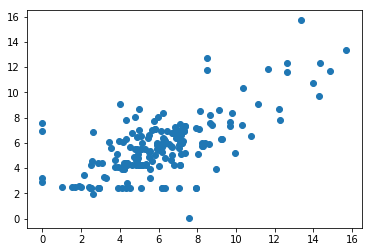

In [10]:
plt.scatter(res_df['actual'], res_df['predicted'])

In [11]:
res_df.to_csv('../data/results/actual_v_predicted_geom_only.csv', sep=',')